In [ ]:
# !pip install -r requirements.txt

In [1]:
import gc
import inspect
from collections import Counter

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq, set_seed

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Data Exploration

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(3)

,Prompt,Sequence of Nodes
0,Trigger an alert when a variable changes to 't...,"[OnVariableChange],[Alert],[Log]"
1,Assign a new value to a variable when it chang...,"[OnVariableChange],[Assign],[Show]"
2,Send a request when a variable changes and upd...,"[OnVariableChange],[SendRequest],[Update]"


In [5]:
df['Prompt'][0]

"Trigger an alert when a variable changes to 'true' and log the event."

In [6]:
df['Nodes List'] = df['Sequence of Nodes'].apply(lambda x: x.strip("[]").split("],["))
df['Nodes List'].head(3)

0             [OnVariableChange, Alert, Log]
1           [OnVariableChange, Assign, Show]
2    [OnVariableChange, SendRequest, Update]
Name: Nodes List, dtype: object

In [7]:
# Flatten the list of all nodes and count occurrences
all_nodes = [node for nodes_list in df['Nodes List'] for node in nodes_list]
node_counts = Counter(all_nodes)
# Convert the counter to a DataFrame for easy viewing
node_counts_df = pd.DataFrame(node_counts.items(), columns=['Node', 'Count'])
node_counts_df.head(3)

,Node,Count
0,OnVariableChange,20
1,Alert,13
2,Log,54


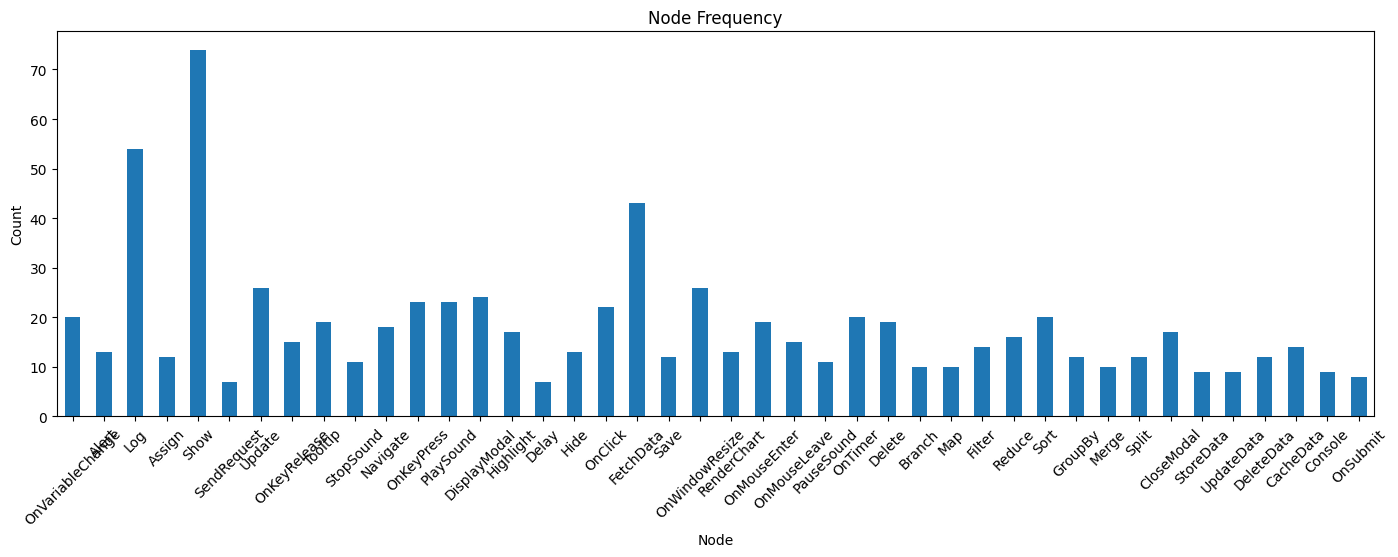

In [8]:
# Plot the counts as a histogram
plt.figure(figsize=[17, 5])
node_counts_df.plot(kind='bar', x='Node', y='Count', legend=False, ax=plt.gca())
plt.title('Node Frequency')
plt.xlabel('Node')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Print least repeated node names
node_counts_df[node_counts_df['Count'] == node_counts_df['Count'].min()]

,Node,Count
5,SendRequest,7
15,Delay,7


# Tokenize words and prepare dataset class

In [10]:
# Load the pre-trained flan-t5 tokenizer

model_name = 'google/flan-t5-small'
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

print('Special tokens:', tokenizer.all_special_tokens)
print('Numer of unique tokens:', len(tokenizer))

Special tokens: ['</s>', '<unk>', '<pad>', '<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>', '<extra_id_46>', '<extra_id_47>', '<extra_id_48>', '<extra_id_49>', '<extra_id_50>', '<extra_id_51>', '<extra_id_52>', '<extra_id_53>', '<extra_id_54>', '<extra_id_55>', '<extra_id_56>'

In [11]:
example = "A brown fox jumps over the lazy dog"
token_ids = tokenizer.encode(example)
print("Example tokenization:")
print("\t Sentence: ", example)
print('\t Tokens: ', tokenizer.decode(token_ids, skip_special_tokens=False))

Example tokenization:
	 Sentence:  A brown fox jumps over the lazy dog
	 Tokens:  A brown fox jumps over the lazy dog</s>


### Create pandas dataframe with text ready to be tokenized

In [12]:
df['concatenated_node_names'] = df['Sequence of Nodes'].apply(
    lambda x: ' '.join(x.strip("[]").split("],[")))
df['concatenated_node_names'].head(3)

0             OnVariableChange Alert Log
1           OnVariableChange Assign Show
2    OnVariableChange SendRequest Update
Name: concatenated_node_names, dtype: object

In [13]:
sample_text = df['concatenated_node_names'][0]
sample_tokens = tokenizer.encode(sample_text, truncation=True, max_length=tokenizer.model_max_length)
print('Sample text: ', sample_text)
print("Tokens: ", sample_tokens)
for token in sample_tokens:
    print(f'\tToken:  {tokenizer.decode(token)} = {token}')

Sample text:  OnVariableChange Alert Log
Tokens:  [461, 553, 1665, 179, 3541, 3280, 23951, 7736, 1]
	Token:  On = 461
	Token:  V = 553
	Token:  ari = 1665
	Token:  able = 179
	Token:  Ch = 3541
	Token:  ange = 3280
	Token:  Alert = 23951
	Token:  Log = 7736
	Token:  </s> = 1


### Split data

In [14]:
raw_datasets = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=42)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Prompt', 'Sequence of Nodes', 'Nodes List', 'concatenated_node_names'],
        num_rows: 244
    })
    test: Dataset({
        features: ['Prompt', 'Sequence of Nodes', 'Nodes List', 'concatenated_node_names'],
        num_rows: 62
    })
})

In [15]:
tokenizer.model_max_length

512

In [16]:
def tokenize_function(example):
    example['input_ids'] = tokenizer(example['Prompt'], padding=True, truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["concatenated_node_names"], padding=True, truncation=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(
    ['Prompt', 'Sequence of Nodes', 'Nodes List', 'concatenated_node_names'])
tokenized_datasets

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 244
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 62
    })
})

## Training/validation loops

### Create a DataLoader classes

In [17]:
set_seed(42)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=original_model, padding='longest',
                                       return_tensors="pt")
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=1, collate_fn=data_collator
    # higher batch size did not show good result!
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], shuffle=False, batch_size=64, collate_fn=data_collator
)

In [18]:
for batch in eval_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([62, 34]),
 'attention_mask': torch.Size([62, 34]),
 'labels': torch.Size([62, 18]),
 'decoder_input_ids': torch.Size([62, 18])}

In [19]:
batch['labels']

tensor([[  461,   329,  1162,  ...,     0,     0,     0],
        [  461,   329,  1162,  ...,   221,     1,     0],
        [  461, 13368,    52,  ...,     0,     0,     0],
        ...,
        [ 6130, 20367,   377,  ...,     0,     0,     0],
        [ 3111,  7736,     1,  ...,     0,     0,     0],
        [  374,  5595,  3111,  ...,     0,     0,     0]])

In [20]:
batch['decoder_input_ids']

tensor([[    0,   461,   329,  ...,     0,     0,     0],
        [    0,   461,   329,  ...,  2018,   221,     1],
        [    0,   461, 13368,  ...,     0,     0,     0],
        ...,
        [    0,  6130, 20367,  ...,     0,     0,     0],
        [    0,  3111,  7736,  ...,     0,     0,     0],
        [    0,   374,  5595,  ...,     0,     0,     0]])

In [21]:
with torch.no_grad():
    outputs = original_model(**batch)
    print(outputs.loss, outputs.logits.shape)

tensor(30.3750, dtype=torch.bfloat16) torch.Size([62, 18, 32128])


In [22]:
tokenizer.decode(batch['input_ids'][0], skip_special_tokens=False)

'Highlight a text box when the mouse enters and display a tooltip.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [23]:
tokenizer.decode(batch['labels'][0], skip_special_tokens=False)

'OnMouseEnter Highlight Tooltip</s><pad><pad><pad><pad><pad><pad><pad><pad>'

### Create PEFT model

In [24]:
# !pip install peft==0.3.0 --quiet

In [25]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 76961152
all model parameters: 76961152
percentage of trainable model parameters: 100.00%


In [26]:
lora_config = LoraConfig(
    r=32,  # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM  # FLAN-T5
)

In [27]:
lora_config.inference_mode

False

In [28]:
peft_model = get_peft_model(original_model,
                            lora_config)

In [29]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 1376256
all model parameters: 78337408
percentage of trainable model parameters: 1.76%


In [30]:
peft_model.to(device);

### Create custom training loop

In [31]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Prompt', 'Sequence of Nodes', 'Nodes List', 'concatenated_node_names'],
        num_rows: 244
    })
    test: Dataset({
        features: ['Prompt', 'Sequence of Nodes', 'Nodes List', 'concatenated_node_names'],
        num_rows: 62
    })
})

In [32]:
@torch.no_grad()
def generate_text(model, split, dataset):
    set_seed(42)
    gt_labels = []
    model_generated = []
    for i in tqdm(range(len(dataset[split]))):
        input_text = pd.DataFrame(dataset[split])['Prompt'][i]
        # Tokenize input
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        output = model.generate(input_ids=input_ids.to(device),
                                do_sample=True,
                                max_new_tokens=30,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                top_k=20,
                                top_p=0.95,
                                )

        # Decode the output
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        model_generated.append(decoded_output)

        gt_label = ' '.join(pd.DataFrame(dataset[split])['Nodes List'][i])
        gt_labels.append(gt_label)
    return model_generated, gt_labels


rouge = evaluate.load('rouge')


def compute_rouge(model, split, dataset):
    model.eval()
    model_generated, gt_labels = generate_text(model=model, split=split, dataset=dataset)
    results = rouge.compute(predictions=model_generated,
                            references=gt_labels,
                            use_aggregator=True,
                            use_stemmer=True,
                            )
    return results


compute_rouge(model=peft_model, split='test', dataset=raw_datasets)

  0%|          | 0/62 [00:00<?, ?it/s]

{'rouge1': 0.07961064388171649,
 'rouge2': 0.0,
 'rougeL': 0.07997793405351081,
 'rougeLsum': 0.0807275359021839}

In [33]:
def configure_optimizers(model, weight_decay, learning_rate, device_type):
    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in model.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
    return optimizer


optimizer = configure_optimizers(model=peft_model, weight_decay=0.1, learning_rate=1e-3, device_type=device)

num decayed parameter tensors: 96, with 1,376,256 parameters
num non-decayed parameter tensors: 0, with 0 parameters


In [34]:
best_val_rouge1 = -1


def train_loop(model, num_epochs, eval_every_epoch=2):
    global best_val_rouge1
    model.train()
    train_loss_list = []
    for epoch in range(num_epochs):
        print('Epoch: ', epoch)
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # clip grads
            optimizer.step()
            train_loss_list.append(loss.item())
        train_loss = np.mean(train_loss_list)
        print(f'Epoch {epoch} train loss: {round(train_loss, 4)}')
        train_loss_list = []
        if epoch % eval_every_epoch and epoch > 0:
            print('\tEval...')
            rouge1 = compute_rouge(model=model, split='test', dataset=raw_datasets)['rouge1']
            model.train()
            print('\tEvaluation rouge1 score:', round(rouge1, 5), end=' <> ')
            if rouge1 > best_val_rouge1:
                best_val_rouge1 = rouge1
                peft_model_path = 't5_adapter_ckpt'
                model.save_pretrained(peft_model_path)
                # torch.save(model, 't5_best_val_rouge1_model.pt')
            print('Best val rouge1 up to now: ', round(best_val_rouge1, 5))

In [35]:
train_loop(model=peft_model, num_epochs=50)

Epoch:  0


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 0 train loss: 6.7894
Epoch:  1


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 1 train loss: 2.5681
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.51396 <> Best val rouge1 up to now:  0.51396
Epoch:  2


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 2 train loss: 2.0901
Epoch:  3


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 3 train loss: 1.8873
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.66359 <> Best val rouge1 up to now:  0.66359
Epoch:  4


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 4 train loss: 1.7639
Epoch:  5


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 5 train loss: 1.6757
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.63776 <> Best val rouge1 up to now:  0.66359
Epoch:  6


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 6 train loss: 1.5642
Epoch:  7


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 7 train loss: 1.5543
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.7413 <> Best val rouge1 up to now:  0.7413
Epoch:  8


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 8 train loss: 1.4933
Epoch:  9


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 9 train loss: 1.4897
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.75906 <> Best val rouge1 up to now:  0.75906
Epoch:  10


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 10 train loss: 1.4106
Epoch:  11


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 11 train loss: 1.3953
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.8187 <> Best val rouge1 up to now:  0.8187
Epoch:  12


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 12 train loss: 1.428
Epoch:  13


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 13 train loss: 1.4267
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.79052 <> Best val rouge1 up to now:  0.8187
Epoch:  14


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 14 train loss: 1.3855
Epoch:  15


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 15 train loss: 1.3813
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.79033 <> Best val rouge1 up to now:  0.8187
Epoch:  16


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 16 train loss: 1.3737
Epoch:  17


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 17 train loss: 1.3592
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.79078 <> Best val rouge1 up to now:  0.8187
Epoch:  18


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 18 train loss: 1.3428
Epoch:  19


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 19 train loss: 1.367
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.82817 <> Best val rouge1 up to now:  0.82817
Epoch:  20


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 20 train loss: 1.348
Epoch:  21


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 21 train loss: 1.3239
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.7865 <> Best val rouge1 up to now:  0.82817
Epoch:  22


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 22 train loss: 1.3545
Epoch:  23


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 23 train loss: 1.3267
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.77654 <> Best val rouge1 up to now:  0.82817
Epoch:  24


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 24 train loss: 1.3459
Epoch:  25


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 25 train loss: 1.3615
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.81284 <> Best val rouge1 up to now:  0.82817
Epoch:  26


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 26 train loss: 1.3142
Epoch:  27


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 27 train loss: 1.3159
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.84257 <> Best val rouge1 up to now:  0.84257
Epoch:  28


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 28 train loss: 1.3444
Epoch:  29


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 29 train loss: 1.3304
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.85015 <> Best val rouge1 up to now:  0.85015
Epoch:  30


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 30 train loss: 1.3366
Epoch:  31


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 31 train loss: 1.3136
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.83802 <> Best val rouge1 up to now:  0.85015
Epoch:  32


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 32 train loss: 1.2916
Epoch:  33


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 33 train loss: 1.2853
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.861 <> Best val rouge1 up to now:  0.861
Epoch:  34


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 34 train loss: 1.2788
Epoch:  35


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 35 train loss: 1.263
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.82497 <> Best val rouge1 up to now:  0.861
Epoch:  36


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 36 train loss: 1.2895
Epoch:  37


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 37 train loss: 1.271
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.77227 <> Best val rouge1 up to now:  0.861
Epoch:  38


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 38 train loss: 1.2839
Epoch:  39


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 39 train loss: 1.298
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.88034 <> Best val rouge1 up to now:  0.88034
Epoch:  40


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 40 train loss: 1.2948
Epoch:  41


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 41 train loss: 1.294
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.83721 <> Best val rouge1 up to now:  0.88034
Epoch:  42


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 42 train loss: 1.3017
Epoch:  43


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 43 train loss: 1.302
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.85358 <> Best val rouge1 up to now:  0.88034
Epoch:  44


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 44 train loss: 1.3131
Epoch:  45


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 45 train loss: 1.3204
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.82361 <> Best val rouge1 up to now:  0.88034
Epoch:  46


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 46 train loss: 1.2627
Epoch:  47


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 47 train loss: 1.2573
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.81254 <> Best val rouge1 up to now:  0.88034
Epoch:  48


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 48 train loss: 1.2656
Epoch:  49


  0%|          | 0/244 [00:00<?, ?it/s]

Epoch 49 train loss: 1.2772
	Eval...


  0%|          | 0/62 [00:00<?, ?it/s]

	Evaluation rouge1 score: 0.86075 <> Best val rouge1 up to now:  0.88034


### Training took only 0.5 GB of GPU memory!!!

# Evaluate the model and Generate outputs

In [36]:
from peft import PeftModel

In [37]:
del original_model, peft_model
gc.collect()
torch.cuda.empty_cache()

In [38]:
model_name = 'google/flan-t5-small'
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
model = PeftModel.from_pretrained(original_model, model_id="t5_adapter_ckpt", is_trainable=False,
                                  torch_dtype=torch.bfloat16)
model.merge_and_unload()  # merge lora layers back into weights matrix
model.to(device)

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(in_features=512, out_features=384, bias=False)
                  (k): Linear(in_features=512, out_features=384, bias=False)
                  (v): Linear(in_features=512, out_features=384, bias=False)
                  (o): Linear(in_features=384, out_features=512, bias=False)
                  (relative_attention_bias): Embedding(32, 6)
                )
                (layer_norm): T5LayerNorm()
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (1): T5LayerFF(
                (DenseReluDense): T5DenseGatedActDense(
                  (wi_0): Linear(in

In [39]:
compute_rouge(model=model, split='train', dataset=raw_datasets)

  0%|          | 0/244 [00:00<?, ?it/s]

{'rouge1': 0.9674863387978142,
 'rouge2': 0.9283079625292743,
 'rougeL': 0.9674814597970338,
 'rougeLsum': 0.9677644418423108}

In [40]:
compute_rouge(model=model, split='test', dataset=raw_datasets)

  0%|          | 0/62 [00:00<?, ?it/s]

{'rouge1': 0.880337941628264,
 'rouge2': 0.7698924731182795,
 'rougeL': 0.8815412186379926,
 'rougeLsum': 0.8818612391193035}

In [41]:
# !pip freeze > requirements.txt

### Generate text

In [42]:
@torch.no_grad()
def print_generated_text(model, split, dataset):
    set_seed(42)
    for i in range(len(dataset[split])):
        input_text = pd.DataFrame(dataset[split])['Prompt'][i]

        # Tokenize input
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        output = model.generate(input_ids=input_ids.to(device),
                                do_sample=True,
                                max_new_tokens=30,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                top_k=20,
                                top_p=0.95,
                                )

        # Decode the output
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

        print("Prompt text:")
        print(input_text)
        print("Generated text:")
        print(decoded_output)
        print('Label text:')
        print(' '.join(pd.DataFrame(dataset[split])['Nodes List'][i]))
        print('*' * 50 + f'{i}' + '*' * 50)

In [43]:
print_generated_text(model=model, split='test', dataset=raw_datasets)

Prompt text:
Highlight a text box when the mouse enters and display a tooltip.
Generated text:
OnMouseEnter Highlight Tooltip
Label text:
OnMouseEnter Highlight Tooltip
**************************************************0**************************************************
Prompt text:
Highlight an element on mouse enter and hide the highlight on mouse leave.
Generated text:
OnMouseEnter Highlight OnMouseLeave Hide
Label text:
OnMouseEnter Highlight OnMouseLeave Hide
**************************************************1**************************************************
Prompt text:
Display a modal dialog when a timer triggers every 5 seconds.
Generated text:
OnTimer DisplayModal
Label text:
OnTimer DisplayModal
**************************************************2**************************************************
Prompt text:
Log a message when the mouse enters a button area.
Generated text:
OnMouseEnter Log
Label text:
OnMouseEnter Log
**************************************************3*****